In [ ]:
import numpy as np
import pandas as pd
import os
import sys

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch==2.5.1+cu124 torchvision==0.20.1+cu124 torchaudio==2.5.1+cu124 --index-url https://download.pytorch.org/whl/cu124

Looking in indexes: https://download.pytorch.org/whl/cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 61.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 56.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

In [ ]:
%env TORCH_USE_CUDA_DSA=1
%env CUDA_LAUNCH_BLOCKING=1
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt
%matplotlib inline

env: TORCH_USE_CUDA_DSA=1
env: CUDA_LAUNCH_BLOCKING=1


In [ ]:
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm
from torchvision.utils import draw_bounding_boxes

In [ ]:
print(torch.__version__)
print(torchvision.__version__)

2.5.1+cu124
0.20.1+cu124


In [ ]:
# !pip install pycocotools
from pycocotools.coco import COCO

In [ ]:
from albumentations.pytorch import ToTensorV2

In [ ]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(512, 512),
            A.RandomBrightnessContrast(p=0.5),
            A.GaussianBlur(p=0.5),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))

    else:
        transform = A.Compose([
            A.Resize(512, 512),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))

    return transform

In [ ]:
class DOTADETECTION(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "DOTA_1.5.json"))
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]


    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, "images", path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)

        boxes = [t['bbox'] + [t['category_id']] for t in target]
        h, w, _ = image.shape

        normalized_boxes = []
        for box in boxes:
            x_min = box[0] / w
            y_min = box[1] / h
            x_max = (box[0] + box[2]) / w
            y_max = (box[1] + box[3]) / h
            normalized_boxes.append([x_min, y_min, x_max - x_min, y_max - y_min, box[4]])

        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=normalized_boxes)

        image = transformed['image']
        boxes = transformed['bboxes']

        denormalized_boxes = []
        for box in boxes:
            x_min = box[0] * w
            y_min = box[1] * h
            x_max = (box[0] + box[2]) * w
            y_max = (box[1] + box[3]) * h
            denormalized_boxes.append([x_min, y_min, x_max, y_max])

        boxes = torch.tensor(denormalized_boxes, dtype=torch.float32)

        targ = {}
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] + 1 for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ

    def __len__(self):
        return len(self.ids)

In [ ]:
dataset_path = "/content/drive/MyDrive/dota_dataset"

In [ ]:
#load classes
coco = COCO(os.path.join(dataset_path, "train", "DOTA_1.5.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=3.44s)
creating index...
index created!


{1: {'id': 1, 'name': 'plane', 'supercategory': 'plane'},
 2: {'id': 2, 'name': 'baseball-diamond', 'supercategory': 'baseball-diamond'},
 3: {'id': 3, 'name': 'bridge', 'supercategory': 'bridge'},
 4: {'id': 4,
  'name': 'ground-track-field',
  'supercategory': 'ground-track-field'},
 5: {'id': 5, 'name': 'small-vehicle', 'supercategory': 'small-vehicle'},
 6: {'id': 6, 'name': 'large-vehicle', 'supercategory': 'large-vehicle'},
 7: {'id': 7, 'name': 'ship', 'supercategory': 'ship'},
 8: {'id': 8, 'name': 'tennis-court', 'supercategory': 'tennis-court'},
 9: {'id': 9, 'name': 'basketball-court', 'supercategory': 'basketball-court'},
 10: {'id': 10, 'name': 'storage-tank', 'supercategory': 'storage-tank'},
 11: {'id': 11,
  'name': 'soccer-ball-field',
  'supercategory': 'soccer-ball-field'},
 12: {'id': 12, 'name': 'roundabout', 'supercategory': 'roundabout'},
 13: {'id': 13, 'name': 'harbor', 'supercategory': 'harbor'},
 14: {'id': 14, 'name': 'swimming-pool', 'supercategory': 'swimm

In [ ]:
classes = [i[1]['name'] for i in categories.items()]
classes

['plane',
 'baseball-diamond',
 'bridge',
 'ground-track-field',
 'small-vehicle',
 'large-vehicle',
 'ship',
 'tennis-court',
 'basketball-court',
 'storage-tank',
 'soccer-ball-field',
 'roundabout',
 'harbor',
 'swimming-pool',
 'helicopter',
 'container-crane']

In [ ]:
train_dataset = DOTADETECTION(root=dataset_path, transforms=get_transforms(True))

loading annotations into memory...
Done (t=2.99s)
creating index...
index created!


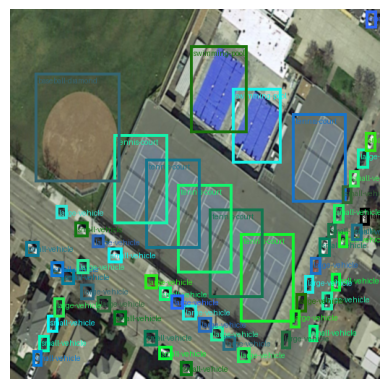

In [ ]:
sample = train_dataset[0]

image_tensor = (sample[0] * 255).to(torch.uint8)

boxes = sample[1]['boxes']
labels = [classes[i.item()-2] for i in sample[1]['labels']]

boxed_image = draw_bounding_boxes(image_tensor, boxes, labels, width=4)

plt.imshow(boxed_image.permute(1, 2, 0))
plt.axis('off')
plt.show()

In [ ]:
len(train_dataset)
# print("Labels in dataset:", set([ann['category_id'] for ann in coco.anns.values()]))

1410

In [ ]:
model = models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)
print(in_features, n_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 155MB/s]


1024 16


In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, collate_fn=collate_fn)

In [ ]:
# images,targets = next(iter(train_loader))
# images = list(image for image in images)
# targets = [{k:v for k, v in t.items()} for t in targets]
# output = model(images, targets)

In [ ]:
device = torch.device("cuda")

In [ ]:
model = model.to(device)

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, nesterov=True, weight_decay=1e-4)

criterion = nn.CrossEntropyLoss()

In [ ]:
import gc

def free_memory():
    torch.cuda.empty_cache()
    gc.collect()

In [ ]:
def train_one_epoch_frcnn(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()
    torch.autograd.set_detect_anomaly(True)

    all_losses = []
    all_losses_dict = []

    for i, (images, targets) in enumerate(tqdm(loader)):
        try:
            images = [image.to(device) for image in images]
            targets = [{k: torch.as_tensor(v).to(device) for k, v in t.items()} for t in targets]

            for target in targets:
                target["labels"] = torch.as_tensor(target["labels"], dtype=torch.int64).to(device)
                target["labels"] -= 2

                if target["labels"].min() < 0 or target["labels"].max() >= n_classes:
                    print(f"⚠️ Skipping batch {i} due to invalid labels: {target['labels']}")
                    raise ValueError("Invalid label range.")

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
            loss_value = losses.item()

            if not math.isfinite(loss_value):
                print(f"⚠️ Skipping batch {i} due to NaN loss: {loss_dict}")
                raise ValueError("NaN loss detected.")

            all_losses.append(loss_value)
            all_losses_dict.append(loss_dict_append)

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            del images, targets, loss_dict, losses
            free_memory()

        except RuntimeError as e:
            if "CUDA" in str(e):
                print(f"\n⚠️ Skipping batch {i} due to CUDA error: {e}")
                free_memory()
                continue
            else:
                print(f"\n⚠️ Unexpected error in batch {i}: {e}")
                raise e

        except ValueError as e:
            print(f"\n⚠️ Skipping batch {i}: {e}")
            free_memory()
            continue

    if all_losses_dict:
        all_losses_dict = pd.DataFrame(all_losses_dict)
        avg_losses = {
            "loss": np.mean(all_losses),
            "loss_classifier": all_losses_dict["loss_classifier"].mean(),
            "loss_box_reg": all_losses_dict["loss_box_reg"].mean(),
            "loss_rpn_box_reg": all_losses_dict["loss_rpn_box_reg"].mean(),
            "loss_objectness": all_losses_dict["loss_objectness"].mean(),
        }
        print("\n\n\n Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
            epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
            all_losses_dict['loss_classifier'].mean(),
            all_losses_dict['loss_box_reg'].mean(),
            all_losses_dict['loss_rpn_box_reg'].mean(),
            all_losses_dict['loss_objectness'].mean()
        ))
    else:
        print(f"Epoch {epoch} finished, but all batches were skipped due to errors.")
        avg_losses = None

    return avg_losses

In [ ]:
num_epochs = 25
checkpoint_path = "/content/drive/MyDrive/dota_dataset/models/frcnn/"
os.makedirs(checkpoint_path, exist_ok=True)

epochs_list = []
total_loss_list = []
loss_classifier_list = []
loss_box_list = []
loss_rpn_box_list = []
loss_object_list = []

start_epoch = 0
checkpoint_file = os.path.join(checkpoint_path, "frcnn_checkpoint1.pth")

if os.path.exists(checkpoint_file):
    checkpoint = torch.load(checkpoint_file)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    start_epoch = checkpoint["epoch"] + 1
    print(f"Resuming training from epoch {start_epoch}...")

start_time = time.time()

for epoch in range(start_epoch, num_epochs):
    loss_dict = train_one_epoch_frcnn(model, optimizer, train_loader, device, epoch)

    total_loss = loss_dict["loss"].item()
    loss_classifier = loss_dict["loss_classifier"].item()
    loss_box = loss_dict["loss_box_reg"].item()
    loss_rpn_box = loss_dict["loss_rpn_box_reg"].item()
    loss_object = loss_dict["loss_objectness"].item()

    epochs_list.append(epoch)
    total_loss_list.append(total_loss)
    loss_classifier_list.append(loss_classifier)
    loss_box_list.append(loss_box)
    loss_rpn_box_list.append(loss_rpn_box)
    loss_object_list.append(loss_object)

    if (epoch + 1) % 5 == 0:
        checkpoint_data = {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "losses": {
                "epochs": epochs_list,
                "total_loss": total_loss_list,
                "loss_classifier": loss_classifier_list,
                "loss_box": loss_box_list,
                "loss_rpn_box": loss_rpn_box_list,
                "loss_object": loss_object_list,
            },
        }
        torch.save(checkpoint_data, checkpoint_file)
        print(f"Checkpoint saved at epoch {epoch + 1}")

end_time = time.time()
elapsed_time = (end_time - start_time) / 60
print(f"Training time: {elapsed_time:.2f} minutes")

losses_data = {
    "epochs": epochs_list,
    "total_loss": total_loss_list,
    "loss_classifier": loss_classifier_list,
    "loss_box": loss_box_list,
    "loss_rpn_box": loss_rpn_box_list,
    "loss_object": loss_object_list,
}
torch.save(losses_data, os.path.join(checkpoint_path, "losses.pth"))

Resuming training from epoch 5...


  2%|▏         | 7/353 [00:20<12:12,  2.12s/it]


⚠️ Skipping batch 7 due to CUDA error: CUDA out of memory. Tried to allocate 3.24 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.19 GiB is free. Process 3863 has 12.55 GiB memory in use. Of the allocated memory 12.20 GiB is allocated by PyTorch, and 221.94 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 87%|████████▋ | 307/353 [10:23<01:30,  1.96s/it]


⚠️ Skipping batch 307 due to CUDA error: CUDA out of memory. Tried to allocate 1.34 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.18 GiB is free. Process 3863 has 13.56 GiB memory in use. Of the allocated memory 13.20 GiB is allocated by PyTorch, and 222.84 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 93%|█████████▎| 327/353 [11:03<00:50,  1.93s/it]


⚠️ Skipping batch 327 due to CUDA error: CUDA out of memory. Tried to allocate 2.63 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.83 GiB is free. Process 3863 has 12.90 GiB memory in use. Of the allocated memory 11.46 GiB is allocated by PyTorch, and 1.30 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


100%|██████████| 353/353 [11:52<00:00,  2.02s/it]





 Epoch 5, lr: 0.005000, loss: 1.066343, loss_classifier: 0.290287, loss_box: 0.280453, loss_rpn_box: 0.292939, loss_object: 0.202664


 58%|█████▊    | 204/353 [06:13<04:52,  1.96s/it]


⚠️ Skipping batch 204 due to CUDA error: CUDA out of memory. Tried to allocate 3.24 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.13 GiB is free. Process 3863 has 12.61 GiB memory in use. Of the allocated memory 12.22 GiB is allocated by PyTorch, and 256.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 82%|████████▏ | 290/353 [08:50<01:37,  1.55s/it]


⚠️ Skipping batch 289 due to CUDA error: CUDA out of memory. Tried to allocate 1.34 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.17 GiB is free. Process 3863 has 13.57 GiB memory in use. Of the allocated memory 13.23 GiB is allocated by PyTorch, and 215.15 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


100%|██████████| 353/353 [10:45<00:00,  1.83s/it]





 Epoch 6, lr: 0.005000, loss: 1.043606, loss_classifier: 0.277735, loss_box: 0.277212, loss_rpn_box: 0.287007, loss_object: 0.201652


 14%|█▍        | 50/353 [01:36<10:15,  2.03s/it]


⚠️ Skipping batch 50 due to CUDA error: CUDA out of memory. Tried to allocate 3.24 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.51 GiB is free. Process 3863 has 13.23 GiB memory in use. Of the allocated memory 12.54 GiB is allocated by PyTorch, and 561.43 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 75%|███████▍  | 264/353 [08:07<02:45,  1.86s/it]


⚠️ Skipping batch 264 due to CUDA error: CUDA out of memory. Tried to allocate 1.34 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.17 GiB is free. Process 3863 has 13.57 GiB memory in use. Of the allocated memory 13.21 GiB is allocated by PyTorch, and 225.21 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


100%|██████████| 353/353 [10:47<00:00,  1.83s/it]





 Epoch 7, lr: 0.005000, loss: 1.011969, loss_classifier: 0.272678, loss_box: 0.276480, loss_rpn_box: 0.274566, loss_object: 0.188245


 10%|█         | 37/353 [01:09<09:39,  1.83s/it]


⚠️ Skipping batch 37 due to CUDA error: CUDA out of memory. Tried to allocate 3.24 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.19 GiB is free. Process 3863 has 12.55 GiB memory in use. Of the allocated memory 12.29 GiB is allocated by PyTorch, and 130.67 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 35%|███▍      | 122/353 [03:47<07:31,  1.95s/it]


⚠️ Skipping batch 122 due to CUDA error: CUDA out of memory. Tried to allocate 1.34 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.19 GiB is free. Process 3863 has 13.55 GiB memory in use. Of the allocated memory 13.21 GiB is allocated by PyTorch, and 210.89 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 92%|█████████▏| 326/353 [09:59<00:49,  1.82s/it]


⚠️ Skipping batch 326 due to CUDA error: CUDA out of memory. Tried to allocate 1.32 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.22 GiB is free. Process 3863 has 13.51 GiB memory in use. Of the allocated memory 13.08 GiB is allocated by PyTorch, and 308.97 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


100%|██████████| 353/353 [10:46<00:00,  1.83s/it]





 Epoch 8, lr: 0.005000, loss: 0.988505, loss_classifier: 0.261166, loss_box: 0.271589, loss_rpn_box: 0.273725, loss_object: 0.182025


 10%|█         | 36/353 [01:08<09:41,  1.83s/it]


⚠️ Skipping batch 36 due to CUDA error: CUDA out of memory. Tried to allocate 3.24 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.71 GiB is free. Process 3863 has 13.03 GiB memory in use. Of the allocated memory 12.43 GiB is allocated by PyTorch, and 479.26 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 77%|███████▋  | 273/353 [08:22<02:23,  1.79s/it]


⚠️ Skipping batch 273 due to CUDA error: CUDA out of memory. Tried to allocate 1.34 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.09 GiB is free. Process 3863 has 13.64 GiB memory in use. Of the allocated memory 13.25 GiB is allocated by PyTorch, and 259.04 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


100%|██████████| 353/353 [10:48<00:00,  1.84s/it]





 Epoch 9, lr: 0.005000, loss: 0.961970, loss_classifier: 0.254125, loss_box: 0.267168, loss_rpn_box: 0.265235, loss_object: 0.175442
Checkpoint saved at epoch 10


 21%|██        | 74/353 [02:21<08:20,  1.80s/it]


⚠️ Skipping batch 73 due to CUDA error: CUDA out of memory. Tried to allocate 1.32 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.19 GiB is free. Process 3863 has 13.55 GiB memory in use. Of the allocated memory 13.11 GiB is allocated by PyTorch, and 310.13 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 55%|█████▍    | 193/353 [05:58<05:24,  2.03s/it]


⚠️ Skipping batch 193 due to CUDA error: CUDA out of memory. Tried to allocate 3.24 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.19 GiB is free. Process 3863 has 12.54 GiB memory in use. Of the allocated memory 12.20 GiB is allocated by PyTorch, and 209.59 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 84%|████████▍ | 298/353 [09:12<01:40,  1.82s/it]


⚠️ Skipping batch 298 due to CUDA error: CUDA out of memory. Tried to allocate 1.34 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.03 GiB is free. Process 3863 has 13.71 GiB memory in use. Of the allocated memory 13.29 GiB is allocated by PyTorch, and 284.45 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


100%|██████████| 353/353 [10:52<00:00,  1.85s/it]





 Epoch 10, lr: 0.005000, loss: 0.940520, loss_classifier: 0.247374, loss_box: 0.265671, loss_rpn_box: 0.258834, loss_object: 0.168641


 42%|████▏     | 149/353 [04:39<06:34,  1.93s/it]


⚠️ Skipping batch 149 due to CUDA error: CUDA out of memory. Tried to allocate 3.24 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.19 GiB is free. Process 3863 has 12.55 GiB memory in use. Of the allocated memory 12.19 GiB is allocated by PyTorch, and 224.31 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 71%|███████   | 249/353 [07:42<03:13,  1.86s/it]


⚠️ Skipping batch 249 due to CUDA error: CUDA out of memory. Tried to allocate 1.34 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.17 GiB is free. Process 3863 has 13.57 GiB memory in use. Of the allocated memory 13.24 GiB is allocated by PyTorch, and 195.97 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


100%|██████████| 353/353 [10:51<00:00,  1.84s/it]





 Epoch 11, lr: 0.005000, loss: 0.915288, loss_classifier: 0.239570, loss_box: 0.265643, loss_rpn_box: 0.247062, loss_object: 0.163014


 30%|███       | 107/353 [03:19<07:12,  1.76s/it]


⚠️ Skipping batch 107 due to CUDA error: CUDA out of memory. Tried to allocate 1.32 GiB. GPU 0 has a total capacity of 14.74 GiB of which 928.12 MiB is free. Process 3863 has 13.83 GiB memory in use. Of the allocated memory 13.14 GiB is allocated by PyTorch, and 572.71 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 57%|█████▋    | 201/353 [06:15<04:43,  1.87s/it]


⚠️ Skipping batch 200 due to CUDA error: CUDA out of memory. Tried to allocate 3.24 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.18 GiB is free. Process 3863 has 12.55 GiB memory in use. Of the allocated memory 12.21 GiB is allocated by PyTorch, and 209.79 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 86%|████████▌ | 302/353 [09:19<01:38,  1.94s/it]


⚠️ Skipping batch 302 due to CUDA error: CUDA out of memory. Tried to allocate 1.34 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.17 GiB is free. Process 3863 has 13.57 GiB memory in use. Of the allocated memory 13.21 GiB is allocated by PyTorch, and 226.25 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


100%|██████████| 353/353 [10:53<00:00,  1.85s/it]





 Epoch 12, lr: 0.005000, loss: 0.914867, loss_classifier: 0.241533, loss_box: 0.260785, loss_rpn_box: 0.247513, loss_object: 0.165036


 38%|███▊      | 135/353 [04:06<06:36,  1.82s/it]


⚠️ Skipping batch 135 due to CUDA error: CUDA out of memory. Tried to allocate 1.34 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.18 GiB is free. Process 3863 has 13.56 GiB memory in use. Of the allocated memory 13.22 GiB is allocated by PyTorch, and 209.80 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 40%|███▉      | 140/353 [04:16<07:06,  2.00s/it]


⚠️ Skipping batch 140 due to CUDA error: CUDA out of memory. Tried to allocate 3.24 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.20 GiB is free. Process 3863 has 12.54 GiB memory in use. Of the allocated memory 12.19 GiB is allocated by PyTorch, and 219.77 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 64%|██████▎   | 225/353 [06:50<03:40,  1.72s/it]


⚠️ Skipping batch 225 due to CUDA error: CUDA out of memory. Tried to allocate 1.32 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.30 GiB is free. Process 3863 has 13.44 GiB memory in use. Of the allocated memory 13.06 GiB is allocated by PyTorch, and 250.51 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


100%|██████████| 353/353 [10:45<00:00,  1.83s/it]





 Epoch 13, lr: 0.005000, loss: 0.882622, loss_classifier: 0.229112, loss_box: 0.260335, loss_rpn_box: 0.238960, loss_object: 0.154215


 41%|████      | 143/353 [04:26<06:02,  1.73s/it]


⚠️ Skipping batch 143 due to CUDA error: CUDA out of memory. Tried to allocate 1.34 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.17 GiB is free. Process 3863 has 13.57 GiB memory in use. Of the allocated memory 13.22 GiB is allocated by PyTorch, and 218.16 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 47%|████▋     | 166/353 [05:08<04:57,  1.59s/it]


⚠️ Skipping batch 165 due to CUDA error: CUDA out of memory. Tried to allocate 1.32 GiB. GPU 0 has a total capacity of 14.74 GiB of which 914.12 MiB is free. Process 3863 has 13.85 GiB memory in use. Of the allocated memory 13.25 GiB is allocated by PyTorch, and 466.24 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 95%|█████████▍| 335/353 [10:16<00:32,  1.82s/it]


⚠️ Skipping batch 335 due to CUDA error: CUDA out of memory. Tried to allocate 3.24 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.20 GiB is free. Process 3863 has 12.54 GiB memory in use. Of the allocated memory 12.19 GiB is allocated by PyTorch, and 218.19 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


100%|██████████| 353/353 [10:50<00:00,  1.84s/it]





 Epoch 14, lr: 0.005000, loss: 0.867862, loss_classifier: 0.225303, loss_box: 0.256401, loss_rpn_box: 0.234270, loss_object: 0.151887
Checkpoint saved at epoch 15


 35%|███▌      | 124/353 [03:51<06:32,  1.71s/it]


⚠️ Skipping batch 123 due to CUDA error: CUDA out of memory. Tried to allocate 1.34 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.15 GiB is free. Process 3863 has 13.59 GiB memory in use. Of the allocated memory 13.23 GiB is allocated by PyTorch, and 225.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 50%|█████     | 177/353 [05:30<05:28,  1.87s/it]


⚠️ Skipping batch 177 due to CUDA error: CUDA out of memory. Tried to allocate 1.32 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.20 GiB is free. Process 3863 has 13.54 GiB memory in use. Of the allocated memory 13.09 GiB is allocated by PyTorch, and 321.05 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


 70%|██████▉   | 247/353 [07:42<03:22,  1.91s/it]


⚠️ Skipping batch 247 due to CUDA error: CUDA out of memory. Tried to allocate 3.24 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.70 GiB is free. Process 3863 has 13.04 GiB memory in use. Of the allocated memory 12.44 GiB is allocated by PyTorch, and 471.39 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


100%|██████████| 353/353 [10:55<00:00,  1.86s/it]





 Epoch 15, lr: 0.005000, loss: 0.852747, loss_classifier: 0.221050, loss_box: 0.257376, loss_rpn_box: 0.228913, loss_object: 0.145408


  7%|▋         | 23/353 [00:45<10:11,  1.85s/it]

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/dota_dataset/models/frcnn/" + "test_weights.pth")

torch.save(model, "/content/drive/MyDrive/dota_dataset/models/frcnn/" + "test.pth")

In [ ]:
checkpoint_file = "/content/drive/MyDrive/dota_dataset/models/frcnn/" + "frcnn_checkpoint.pth"

In [ ]:
checkpoint = torch.load(checkpoint_file, map_location=torch.device('cpu'))

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch'] + 1

print(f"✅ Model loaded from epoch {checkpoint['epoch']}")

✅ Model loaded from epoch 24


In [ ]:
import gc

gc.collect()

torch.cuda.empty_cache()